# Heat Waves Labor Productivity Impact in Switzerland - Results

In [1]:
import numpy as np
import pandas as pd
#from pandas import DataFrame
import matplotlib.pyplot as plt
import matplotlib.colors as colors

%matplotlib inline
import pickle
import palettable
from scipy.sparse import csr_matrix, vstack
from scipy.optimize import curve_fit
import sys 
from netCDF4 import num2date, date2num
import xarray as xr
from netCDF4 import Dataset


sys.path.append('../../src/util')
sys.path.append('../../src/write_entities')

from climada.engine import Impact
from climada.entity import Exposures
from climada.hazard import Hazard


from stacked_grouped_barplot import plot_clustered_stacked
from stacked_grouped_barplot_error \
import plot_clustered_stacked_with_error
from define_exposures import call_exposures
from shapefile_masks import vector_shapefile_mask

fig_dir = '../figures/'




2020-03-02 17:30:22,481 - climada - DEBUG - Loading default config file: /Users/zeliestalhanske/anaconda3/climada_python-1.3.1/climada/conf/defaults.conf


## Impact Switzerland



In [2]:
#First we import and open the pickle file containing a dictionnary of the losses. 
#The dictionnary is a nested dictionnary, with the first layer being the different scenarios, 
#the second the years. For each scenario and each year, there is a panda dataframe 
#with the 4 types of exposures as columns, according to the level of physical activity 
#of the labor performed (the different exposures).
#The rows of the panda dataframe correspond to the output of each Monte Carlo run.

pickle_in = \
open('../../output/impact_ch/impacts_all_branches_1000mc_all_uncertainties_CH.pickle','rb')
loss_CH= pickle.load(pickle_in)  

pickle_in = \
open('../../output/impact_ch/impacts_all_branches_1000mc_all_uncertainties_CH_2065.pickle','rb')
loss_CH_2065= pickle.load(pickle_in)  
for s_ in loss_CH:
    loss_CH[s_]['2065'] = loss_CH_2065[s_]['2065']

# Add a column to each dataframe with the sum of all exposures for each monte carlo.
for s_ in loss_CH:
    for y_ in loss_CH[s_]:     
        loss_CH[s_][y_]['total'] \
        = loss_CH[s_][y_][list(loss_CH[s_][y_].columns)].sum(axis=1)    
RCPs = {'RCP26':'RCP2.6','RCP45':'RCP4.5', 'RCP85':'RCP8.5'} #to get the correct name in the plots


### Distribution of damage costs for each scenario


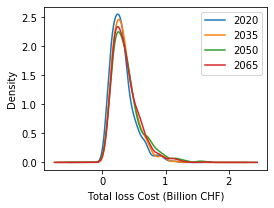

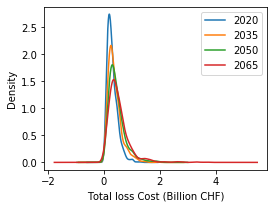

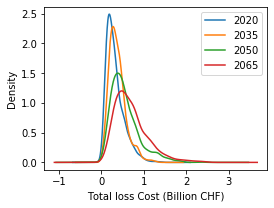

In [845]:
#change structure of dictionnary so that the scenarios are the keys. For each scenario,
#make a new daframe with the years as columns and the total cost for the different 
#simulations in the rows. We can then make a plot of the distribution for each scenario 
#and see how the distribution moves with the years

distribution = {}
for s_ in loss_CH:

    fig, ax = plt.subplots(figsize=(4, 3))
    distribution[s_] = pd.DataFrame()

    for y_ in loss_CH[s_]:
        distribution[s_][y_] = loss_CH[s_][y_]['total']/(10e8) #devide by 10^9 to get billion of CHF
        distribution[s_][y_].plot.kde(label=y_)
        ax.legend()
        ax.set_xlabel('Total loss Cost (Billion CHF)')


    fig_name = ''.join([fig_dir,'loss_ch/loss_distribution','_',s_,'.pdf'])
    plt.savefig(fig_name,bbox_inches='tight')        



### Damage cost for each scenario, year and labor type


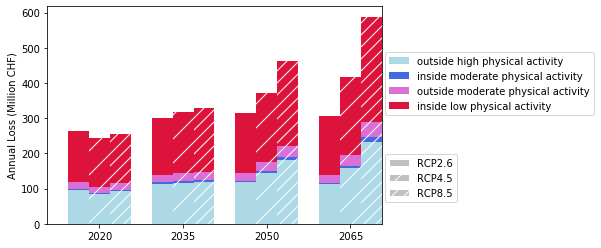

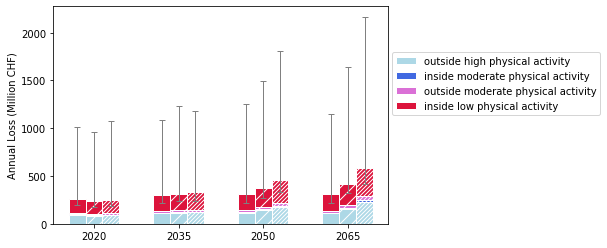

In [846]:
#again, we make a new dictionnary of the scenarios, this time with the different types of exposures
#as columns and the years in the rows. Then, the clustered stacked barplots can be called, 
#with the dictionnary of panda median as input, where the rows of each dataframe correspond to the grouping 
#criteria (by year), the columns to the stacks (the labor types) 
#and the dictionnary keys to the hatches (the scenario).  
RCPs = {'RCP26':'RCP2.6', 'RCP45':'RCP4.5', 'RCP85':'RCP8.5'} 
median = {}
minimums = {}
maximums = {}
for s_ in loss_CH:
    median[RCPs[s_]] = pd.DataFrame()#dataframe containing the median realization for the different exposures
    maximums[RCPs[s_]] = pd.DataFrame() #dataframe containing the 95th percentile realization for the different exposures
    minimums[RCPs[s_]] = pd.DataFrame()#dataframe containing the 5th percentile realization for the different exposures
    
    for y_ in loss_CH[s_]:
        median[RCPs[s_]][y_] = ((loss_CH[s_][y_].iloc[:,0:-1]).median())/1e6  #don't need the total here 
        maximums[RCPs[s_]][y_] = ((loss_CH[s_][y_].iloc[:,0:-1]).quantile(0.95))/1e6 
        minimums[RCPs[s_]][y_] = ((loss_CH[s_][y_].iloc[:,0:-1]).quantile(0.05))/1e6
    

    median[RCPs[s_]] = median[RCPs[s_]].transpose()
    maximums[RCPs[s_]] = maximums[RCPs[s_]].transpose()
    minimums[RCPs[s_]] = minimums[RCPs[s_]].transpose()


fig, ax = plt.subplots()
plot_clustered_stacked(median,title = '',color= ['lightblue','royalblue','orchid','crimson'])
plt.ylabel('Annual Loss (Million CHF)')
ax.ticklabel_format(style='plain')

plt.savefig(''.join([fig_dir,'loss_ch/predicted_loss_2020_2050.pdf']),bbox_inches='tight')

fig, ax = plt.subplots()
plot_clustered_stacked_with_error(median,minimums,maximums,color= ['lightblue','royalblue','orchid','crimson'])
plt.ylabel('Annual Loss (Million CHF)')
plt.savefig(''.join([fig_dir,'loss_ch/predicted_loss_2020_2050_werror.pdf']),bbox_inches='tight')




In [847]:
print('For the 95th percentile realization, the percentage of the loss for the inside low physical activity category is:')
print(maximums['RCP8.5']['inside low physical activity']/maximums['RCP8.5'].sum(axis=1))
print('For the median realization, the percentage of the loss for the inside low physical activity category is:')
print(median['RCP8.5']['inside low physical activity']/median['RCP8.5'].sum(axis=1))


For the 95th percentile realization, the percentage of the loss for the inside low physical activity category is:
2020    0.517512
2035    0.517343
2050    0.472834
2065    0.469317
dtype: float64
For the median realization, the percentage of the loss for the inside low physical activity category is:
2020    0.545745
2035    0.556870
2050    0.521149
2065    0.509488
dtype: float64


## Sensibility Analysis
the analysis was done for the canton of bern, in order to limit the computational power needed. This canton was chosen as being 'representative' of the rest of Switzerland. Only the year 2050 and the RCP 8.5 were run here. 


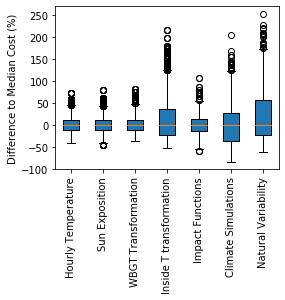

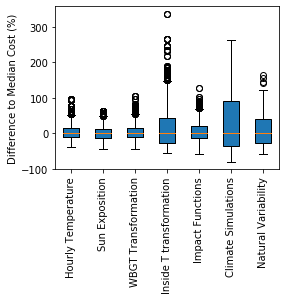

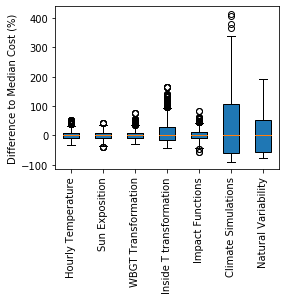

In [849]:
#open the output corresponding to the sensibility. This time, the file is a three layers nested dictionnary
#with the variable being varied (the others are fixes) as the outer level, the scenario as the center and 
#the year as the inner level.

pickle_in =\
open('../../output/impact_sensitivity/sensitivity_all_branches_1000mc_Bern.pickle','rb')
sensitivity1 = pickle.load(pickle_in)

pickle_in =\
open('../../output/impact_sensitivity/sensitivity_all_branches_1000mc_Bern_2.pickle','rb')
sensitivity2 = pickle.load(pickle_in)

pickle_in =\
open('../../output/impact_sensitivity/sensitivity_all_branches_1000mc_Bern_3.pickle','rb')
sensitivity3 = pickle.load(pickle_in)

sensitivity_files = [sensitivity1,sensitivity2,sensitivity3]

c_=1
for sensitivity in sensitivity_files:
#add column with total loss:
    for v_ in sensitivity:
        for s_ in sensitivity[v_]:
            for y_ in sensitivity[v_][s_]: 
                sensitivity[v_][s_][y_]['total'] = sensitivity[v_][s_][y_][list(sensitivity[v_][s_][y_].columns)].sum(axis=1)
    
    scenarios = ['RCP85']
    y = '2050'
    sensitivity_variables = ['Hourly Temperature', 'Sun Exposition', 'WBGT Transformation', 'Inside T transformation','Impact Functions','Climate Simulations','Natural Variability']

    for s_ in scenarios:    
        fig, ax = plt.subplots(figsize = (4,3))
        diff_median = [] #list with the difference to the difference to the median of each run
        for v_ in sensitivity:
            diff_median.append((sensitivity[v_][s_][y_]['total']-np.median(sensitivity[v_][s_][y_]['total']))/np.median(sensitivity[v_][s_][y_]['total'])*100)
            if v_ != 'simulations':
                ax.boxplot(diff_median, patch_artist=True)

    
        #ax.boxplot(diff_median, patch_artist=True)
        ax.set_xticks([1,2,3,4,5,6,7])
        ax.set_ylabel('Difference to Median Cost (%)')

        ax.set_xticklabels(sensitivity_variables,rotation=90)
        plt.savefig(''.join([fig_dir,'sensitivity/',s_,'_','sensitivity_bern_all_',str(c_),'.pdf']),bbox_inches='tight')
        c_=c_+1


### Plotting the Spatial Impact 

In [2]:
#we now open the matrice output which is a three level nested dictionnary with a csr matrix at the end.
#There is one matrix for each combination of scenario, year and exposure type.
#Each matrix corresponds to the median of all the monte carlos for each exposure.

pickle_in = open('../../output/impact_ch/matrix_all_branches_1000mc_all_uncertainties_CH.pickle','rb')
matrices = pickle.load(pickle_in)
    

In [3]:
#we call the exposures to be able to calculate the percentage damaged

directory_exposures          = '../../input_data/exposures/'
exposures   = call_exposures()
for e_ in exposures: # get the yearly value of the exposures, as the exposures from call_exposures() are hourly values
    exposures[e_].value = exposures[e_].value*40*52 # multiply by 40 hours/week x 52 weeks



2020-03-02 17:30:46,828 - climada.util.coordinates - INFO - Setting geometry points.
2020-03-02 17:30:54,220 - climada.entity.exposures.base - INFO - tag metadata set to default value:  File: 
 Description: 
2020-03-02 17:30:54,221 - climada.entity.exposures.base - INFO - ref_year metadata set to default value: 2018
2020-03-02 17:30:54,221 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2020-03-02 17:30:54,222 - climada.entity.exposures.base - INFO - centr_ not set.
2020-03-02 17:30:54,222 - climada.entity.exposures.base - INFO - deductible not set.
2020-03-02 17:30:54,222 - climada.entity.exposures.base - INFO - cover not set.
2020-03-02 17:30:54,223 - climada.entity.exposures.base - INFO - category_id not set.
2020-03-02 17:30:54,223 - climada.entity.exposures.base - INFO - region_id not set.
2020-03-02 17:31:01,301 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2020-03-02 17:31:05,789 - climada.util.coordinates -

calculate percentage of exposures affected

In [8]:
print('the total percentage of the exposures affected in 2050 under an RCP8.5 scenario is:')
total_exposure = sum(exposures[e_].value.sum() for e_ in exposures) 
print((loss_CH['RCP85']['2050']['total'].median()/total_exposure)*100)

print('the percentage affected value for the people inside with low physical activity in 2050 under an RCP8.5 scenariois:')
print((loss_CH['RCP85']['2050']['inside low physical activity'].median()\
       /exposures['inside low physical activity'].value.sum())*100)

print('the percentage affected value for the people outside with high physical activity in 2050 under an RCP8.5 scenariois:')
print((loss_CH['RCP85']['2050']['outside high physical activity'].median()/\
       exposures['outside high physical activity'].value.sum())*100)


print('the percentage affected value for the people outside with moderate physical activity in 2050 under an RCP8.5 scenariois:')
print((loss_CH['RCP85']['2050']['outside moderate physical activity'].median()/\
       exposures['outside moderate physical activity'].value.sum())*100)

print('the percentage affected value for the people inside with moderate physical activity in 2050 under an RCP8.5 scenario is:')
print((loss_CH['RCP85']['2050']['inside moderate physical activity'].median()/\
       exposures['inside moderate physical activity'].value.sum())*100)


print('the total percentage of the exposures affected in 2065 under an RCP8.5 scenario is:')
total_exposure = sum(exposures[e_].value.sum() for e_ in exposures) 
print((loss_CH['RCP85']['2065']['total'].median()/total_exposure)*100)


the total percentage of the exposures affected in 2050 under an RCP8.5 scenario is:
0.1293315015249697
the percentage affected value for the people inside with low physical activity in 2050 under an RCP8.5 scenariois:
0.09698558523821534
the percentage affected value for the people outside with high physical activity in 2050 under an RCP8.5 scenariois:
0.45696213684181913
the percentage affected value for the people outside with moderate physical activity in 2050 under an RCP8.5 scenariois:
0.24487091130681707
the percentage affected value for the people inside with moderate physical activity in 2050 under an RCP8.5 scenario is:
0.014353571701317212
the total percentage of the exposures affected in 2065 under an RCP8.5 scenario is:
0.16701396218653514


rewrite the impact from the impact matrix of the low and high expenditure exposures in the impact class:

In [16]:
#rewrite impacts from impact matrix
median_impact_2050_RCP85_inside_low = Impact()
median_impact_2050_RCP85_inside_low.coord_exp =\
np.stack([exposures['inside low physical activity'].latitude.values,exposures['inside low physical activity'].\
          longitude.values], axis=1)
median_impact_2050_RCP85_inside_low.event_id = np.array([1])
median_impact_2050_RCP85_inside_low.imp_mat =\
csr_matrix((csr_matrix(matrices['RCP85']['2050']['inside low physical activity']).toarray()[0,:]\
            /exposures['inside low physical activity'].value.replace(0, 1))*100) #put impacts in terms of percentage of exposure
median_impact_2050_RCP85_inside_low.unit = '%'

median_impact_2050_RCP85_outside_high = Impact()
median_impact_2050_RCP85_outside_high.coord_exp =\
np.stack([exposures['outside high physical activity'].latitude.values,exposures['outside high physical activity']\
          .longitude.values], axis=1)
median_impact_2050_RCP85_outside_high.event_id = np.array([1])
median_impact_2050_RCP85_outside_high.imp_mat =\
csr_matrix((csr_matrix(matrices['RCP85']['2050']['outside high physical activity']).toarray()[0,:]\
            /exposures['outside high physical activity'].value.replace(0, 1))*100)
median_impact_2050_RCP85_outside_high.unit = '%'

plot the maps for low physical activity exposure in percentage and absolute number. 
Plot the map for the high physical activity exposure in percentage

/Users/zeliestalhanske/anaconda3/climada_python-1.3.1/climada/util/plot.py:318: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()
/Users/zeliestalhanske/anaconda3/climada_python-1.3.1/climada/util/plot.py:318: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


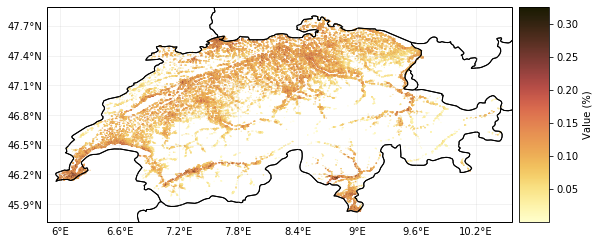

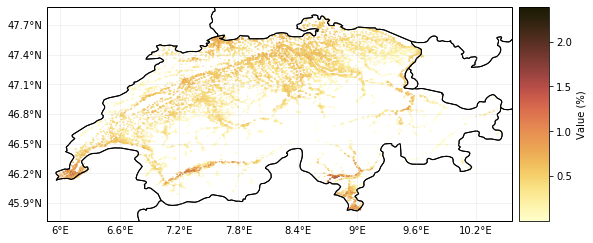

In [5]:
cm= palettable.scientific.sequential.LaJolla_20.mpl_colormap

#plot the impact as a percentage of the total exposures value for the low and high expenditure exposures 
median_impact_2050_RCP85_inside_low.plot_hexbin_impact_exposure(pop_name = False,cmap=cm,buffer=0.1)
plt.savefig(''.join([fig_dir,'loss_ch/ch','_map_low_percentage.pdf']),bbox_inches='tight')


median_impact_2050_RCP85_outside_high.plot_hexbin_impact_exposure(pop_name = False,cmap=cm,buffer=0.1)
plt.savefig(''.join([fig_dir,'loss_ch/ch','_map_high_percentage.pdf']),bbox_inches='tight')




redo for 2035 in order to compare with the data available from the ch2018 web atlas



In [19]:
median_impact_2035_RCP85_inside_low = Impact()
median_impact_2035_RCP85_inside_low.coord_exp =\
np.stack([exposures['inside low physical activity'].latitude.values,exposures\
          ['inside low physical activity'].longitude.values], axis=1)
median_impact_2035_RCP85_inside_low.event_id = 1
median_impact_2035_RCP85_inside_low.imp_mat =\
csr_matrix((matrices['RCP85']['2035']['inside low physical activity'].toarray()[0,:]\
            /exposures['inside low physical activity'].value.replace(0, 1))*100) #put impacts in terms of percentage of exposure
median_impact_2035_RCP85_inside_low.unit = 'CHF'


median_impact_2035_RCP85_outside_high = Impact()
median_impact_2035_RCP85_outside_high.coord_exp =\
np.stack([exposures['outside high physical activity'].latitude.values,\
          exposures['outside high physical activity'].longitude.values], axis=1)
median_impact_2035_RCP85_outside_high.event_id = 1
median_impact_2035_RCP85_outside_high.imp_mat =\
median_impact_2035_RCP85_outside_high.imp_mat =\
csr_matrix((matrices['RCP85']['2035']['outside high physical activity'].toarray()[0,:]\
            /exposures['outside high physical activity'].value.replace(0, 1))*100)
median_impact_2035_RCP85_outside_high.unit = 'CHF'

/Users/zeliestalhanske/anaconda3/climada_python-1.3.1/climada/util/plot.py:318: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


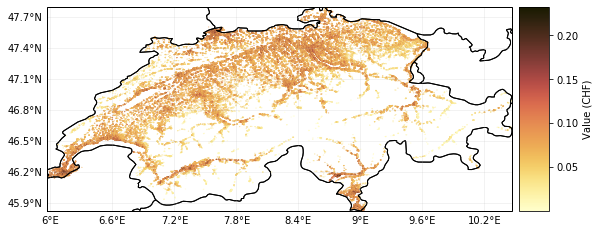

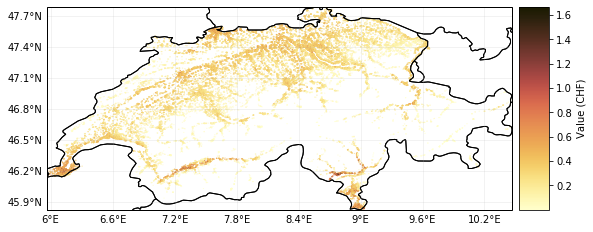

In [21]:
#plot the impact as a percentage of the total exposures value for the low and high expenditure exposures 
median_impact_2035_RCP85_inside_low.plot_hexbin_impact_exposure(event_id=1,pop_name = False,cmap=cm)
plt.savefig(''.join([fig_dir,'loss_ch/ch','_map_low_percentage_2035.pdf']),bbox_inches='tight')

median_impact_2035_RCP85_outside_high.plot_hexbin_impact_exposure(event_id=1,pop_name = False,cmap=cm)
plt.savefig(''.join([fig_dir,'loss_ch/ch','_map_high_percentage_2035.pdf']),bbox_inches='tight')
#plot the impact of the total exposures value for the low and high expenditure exposures 



### testing the correlation between the impacts and the heat days from the ch2018

In [860]:
#transform the impacts to exposures to be able to assign the centroids of the heat days to the impact

impact_as_exposures_high_2035_RCP85 = median_impact_2035_RCP85_outside_high._build_exp_events(1)
impact_as_exposures_low_2035_RCP85 = median_impact_2035_RCP85_inside_low._build_exp_events(1)


In [861]:

# Data for the number of heat days in 2035 under an RCP8.5 scenario
heat_days = xr.open_dataset('/Users/zeliestalhanske/Desktop/Master/Thesis/Hazard/ch2018/data/heat_days/heat_days.nc')

# transform dates to number of days:
heat_days.HD.values= heat_days.HD.values.astype('timedelta64[D]')/np.timedelta64(1, 'D') 

#write as a hazard
np.meshgrid(heat_days.lon.values, heat_days.lat.values)

grid_x, grid_y = np.meshgrid(heat_days.lon.values, heat_days.lat.values)
heat_days = Hazard('HD')
heat_days.centroids.set_lat_lon(grid_y.flatten(), grid_x.flatten(), crs={'init': 'epsg:4326'})
heat_days.units = 'days'
heat_data = heat_days.HD.values
heat_data[np.isnan(heat_data)] = 0.
heat_days.intensity = csr_matrix(heat_data.reshape(1, len(heat_days.lon) *  len(heat_days.lat)))
heat_days.event_id = np.array(len(heat_days.HD.values))
heat_days.fraction = heat_days.intensity.copy()
heat_days.fraction.data.fill(1)

# get the corresponding centroids for each impact/ number of heat days as the resolution is not the same
# This is usually done in CLIMADA to get the corresponding centroids for each exposure. 
# we therefore here have the impacts are Exposures and the heat days as Hazards 
impact_as_exposures_high_2035_RCP85.assign_centroids(heat_days)
impact_as_exposures_low_2035_RCP85.assign_centroids(heat_days)


2020-03-01 14:05:49,196 - climada.entity.exposures.base - INFO - Matching 216100 exposures with 22220 centroids.
2020-03-01 14:05:59,129 - climada.entity.exposures.base - INFO - Matching 216100 exposures with 22220 centroids.
2020-03-01 14:06:09,026 - climada.entity.exposures.base - INFO - Matching 216100 exposures with 22220 centroids.
2020-03-01 14:06:18,776 - climada.entity.exposures.base - INFO - Matching 216100 exposures with 22220 centroids.


In [862]:
# only keep those values where an exposure exists (is not 0)
impact_as_exposures_high_2035_RCP85 = impact_as_exposures_high_2035_RCP85[EXPOSURES['outside high physical activity'].value!=0]
impact_as_exposures_low_2035_RCP85 = impact_as_exposures_low_2035_RCP85[EXPOSURES['inside low physical activity'].value!=0]

#reset the row indexes 
impact_as_exposures_high_2035_RCP85.index = range(len(impact_as_exposures_high_2035_RCP85))
impact_as_exposures_low_2035_RCP85.index = range(len(impact_as_exposures_low_2035_RCP85))


In [865]:
#make new dataframes for the low activity and high activity categories with only the impacts and number of heat days

correlation_high = pd.DataFrame()

correlation_high['heat_days'] = np.zeros(len(impact_as_exposures_high_2035_RCP85))

for i_ in range(len(correlation_high)):
    correlation_high['heat_days'][i_] = heat_days.intensity[0,impact_as_exposures_high_2035_RCP85.centr_HD[i_]]
    
correlation_high['impact'] = impact_as_exposures_high_2035_RCP85['value']

correlation_low = pd.DataFrame()

correlation_low['heat_days'] = np.zeros(len(impact_as_exposures_low_2035_RCP85))

for i_ in range(len(correlation_low)):
    correlation_low['heat_days'][i_] = heat_days.intensity[0,impact_as_exposures_low_2035_RCP85.centr_HD[i_]]
    
correlation_low['impact'] = impact_as_exposures_low_2035_RCP85['value']

,heat_days,impact
heat_days,1.000000,0.978714
impact,0.978714,1.000000


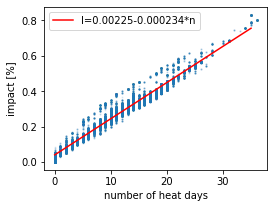

In [867]:
#plot 

m, b = np.polyfit(correlation_high['heat_days'],correlation_high['impact'],1) # linear fit

x=np.arange(max(correlation_high['heat_days']))

fig, ax = plt.subplots(figsize=(4,3))
ax.plot(x, m*x + b, color = 'red',label='I=0.00225-0.000234*n')

correlation_high.plot.scatter('heat_days','impact',ax=ax,s=1,alpha=0.1)
ax.set_ylabel('impact [%]')
ax.set_xlabel('number of heat days')
#ax.set_title('2035 RCP85 outside high physical activity')
ax.legend()
plt.savefig(''.join([fig_dir,'correlation_impact_hd/correlation_high.pdf']),bbox_inches='tight')
correlation_high.corr(method ='pearson') 


,heat_days,impact
heat_days,1.000000,0.923066
impact,0.923066,1.000000


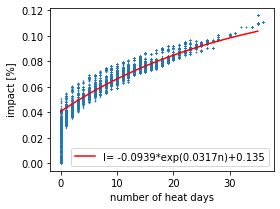

In [749]:
#function guess:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c
    #return a * np.log(b * x + 1) + c

#fit:    
popt, pcov = curve_fit(func, correlation_low['heat_days'][correlation_low['heat_days']>1],correlation_low['impact'][correlation_low['heat_days']>1])

fig, ax = plt.subplots(figsize=(4,3))
plt.plot(x, func(x, *popt),color='red',label='I= -0.0939*exp(0.0317n)+0.135')

correlation_low.plot.scatter('heat_days','impact',ax=ax,s=0.1)
ax.set_ylabel('impact [%]')
ax.set_xlabel('number of heat days')
ax.legend()
plt.savefig(''.join([fig_dir,'correlation_impact_hd/correlation_low.pdf']),bbox_inches='tight')

correlation_low.corr(method ='pearson') 


## Kantons 

The damage for the different kantons can be computed directly from the model, so that we also get the distribution of the probabilistic damage. If we only want the median damage, it can also be optained from the swiss level impact matrix, requiring no further simulations. 

First let's redo the predicted plot for Zurich only:


In [868]:

pickle_in = open('../../output/impact_cantons/impacts_all_branches_1000mc_all_uncertainties_Zürich.pickle','rb')
zurich = pickle.load(pickle_in)



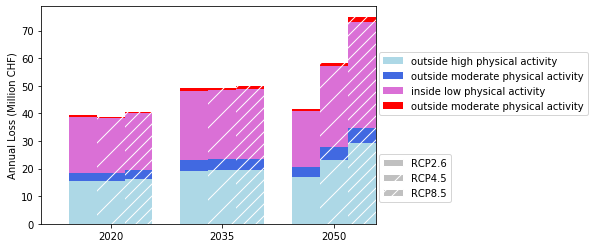

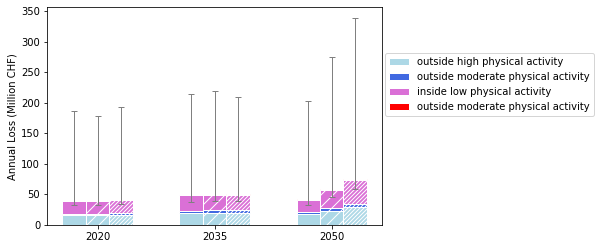

In [869]:
RCP = {'RCP26':'RCP2.6', 'RCP45':'RCP4.5', 'RCP85':'RCP8.5'}


for s_ in zurich:
    for y_ in zurich[s_]:
        zurich[s_][y_]['total'] = zurich[s_][y_][list(zurich[s_][y_].columns)].sum(axis=1)
        
        

median = {}
minimums = {}
maximums = {}
for s_ in zurich:
    median[RCP[s_]] = pd.DataFrame()
    maximums[RCP[s_]] = pd.DataFrame()
    minimums[RCP[s_]] = pd.DataFrame()
    for y_ in zurich[s_]:
        median[RCP[s_]][y_] = ((zurich[s_][y_].iloc[:,0:-1]).median())/1000000
        maximums[RCP[s_]][y_] = (zurich[s_][y_].iloc[:,0:-1].quantile(0.95))/1000000 # max of the error bar, corresponding to the 95th percentile
        minimums[RCP[s_]][y_] = (zurich[s_][y_].iloc[:,0:-1].quantile(0.05))/1000000 # min of the error bar, corresponding to the 5th percentile
    median[RCP[s_]] = median[RCP[s_]].transpose()
    maximums[RCP[s_]] = maximums[RCP[s_]].transpose()
    minimums[RCP[s_]] = minimums[RCP[s_]].transpose()

    
    
fig, ax = plt.subplots()

plot_clustered_stacked(median,title = '',\
                       color= ['lightblue','royalblue','orchid','red'])

plt.ylabel('Annual Loss (Million CHF)')

plt.savefig(''.join([fig_dir,'cantons/predicted_damage_zurich.pdf']),bbox_inches='tight')


fig, ax = plt.subplots()

plot_clustered_stacked_with_error(median,minimums,maximums,color= ['lightblue','royalblue','orchid','red'])
plt.ylabel('Annual Loss (Million CHF)')

plt.savefig(''.join([fig_dir,'cantons/Zurich/predicted_loss_error_zurich.pdf']),bbox_inches='tight')


### Aargau

here we don't rerun the model as was done for Zurich but just get the restults for the canton Aarfau from the impact matrix.

In [884]:
shp_dir = '../../input_data/shapefiles/KANTONS_projected_epsg4326/swissBOUNDARIES3D_1_3_TLM_KANTONSGEBIET_epsg4326.shp'

impact_low_2050 = {} 
impact_high_2050 = {} 
for s_ in matrices: # the impacts are reconstructed and transformed to exposures,
    #as we already have a function for the impact class to mask the values outside the cantons
    impact_low_2050[s_] = Impact()
    impact_low_2050[s_].coord_exp = np.stack([exposures['inside low physical activity']\
                                              .latitude.values,exposures['inside low physical activity'].\
                                              longitude.values], axis=1)
    impact_low_2050[s_].event_id = 1
    impact_low_2050[s_].imp_mat =csr_matrix(matrices[s_]['2050']['inside low physical activity']) 
    impact_low_2050[s_] = impact_low_2050[s_]._build_exp_events(1) # transform to exposures

    impact_high_2050[s_] = Impact()
    impact_high_2050[s_].coord_exp = np.stack([exposures['outside high physical activity'].\
                                               latitude.values,exposures['outside high physical activity'].\
                                               longitude.values], axis=1)
    impact_high_2050[s_].event_id = 1
    impact_high_2050[s_].imp_mat =csr_matrix(matrices[s_]['2050']['outside high physical activity']) 
    impact_high_2050[s_] = impact_high_2050[s_]._build_exp_events(1) #transform to exposures

    

In [874]:
exposures_aargau = call_exposures(kanton = 'Aargau')


In [885]:
aargau_2050_high = vector_shapefile_mask(impact_low_2050['RCP85'],shp_dir,'Aargau',4326,4326)  
aargau_2050_low = vector_shapefile_mask(impact_high_2050['RCP85'],shp_dir,'Aargau',4326,4326)  
aargau_2050_high.value = aargau_2050_high.value/(exposures_aargau['outside high physical activity']\
                                                 .value*40*52)*100
aargau_2050_low.value = aargau_2050_low.value/(exposures_aargau['inside low physical activity'].\
                                               value*40*52)*100

In [886]:
#write as exposures 

aargau_2050_fraction_low               =  Exposures(aargau_2050_low)
aargau_2050_fraction_low.set_lat_lon()
n_exp                               =  len(aargau_2050_low['value'])
aargau_2050_fraction_low['if_HW']      =  np.full((n_exp), 1, dtype=int)
aargau_2050_fraction_low.value_unit    =  '%'
aargau_2050_fraction_low.fillna(0)
aargau_2050_fraction_low.check()       


aargau_2050_fraction_high              =  Exposures(aargau_2050_high)
aargau_2050_fraction_high.set_lat_lon()
n_exp                               =  len(aargau_2050_high['value'])
aargau_2050_fraction_high['if_HW']      =  np.full((n_exp), 1, dtype=int)
aargau_2050_fraction_high.value_unit    =  '%'
aargau_2050_fraction_high.fillna(0)
aargau_2050_fraction_high.check()       


2020-03-01 14:58:41,060 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2020-03-01 14:58:41,457 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-03-01 14:58:41,458 - climada.entity.exposures.base - INFO - tag metadata set to default value:  File: 
 Description: 
2020-03-01 14:58:41,458 - climada.entity.exposures.base - INFO - ref_year metadata set to default value: 2018
2020-03-01 14:58:41,459 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2020-03-01 14:58:41,460 - climada.entity.exposures.base - INFO - centr_ not set.
2020-03-01 14:58:41,460 - climada.entity.exposures.base - INFO - deductible not set.
2020-03-01 14:58:41,461 - climada.entity.exposures.base - INFO - cover not set.
2020-03-01 14:58:41,461 - climada.entity.exposures.base - INFO - category_id not set.
2020-03-01 14:58:41,462 - climada.entity.exposures.base - INFO - region_id not set.
2020-03

2020-03-01 15:02:56,287 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


/Users/zeliestalhanske/anaconda3/climada_python-1.3.1/climada/util/plot.py:318: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


2020-03-01 15:03:04,103 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


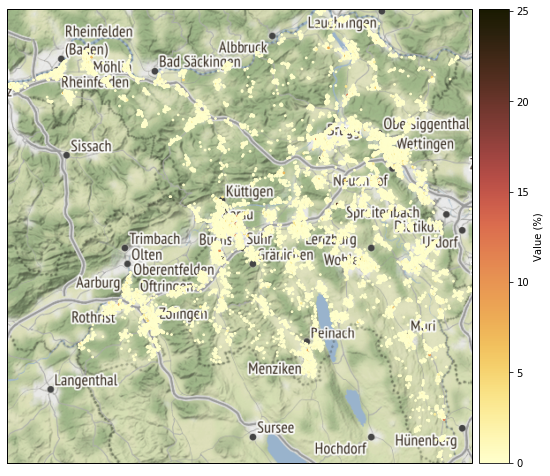

In [887]:

cm= palettable.scientific.sequential.LaJolla_20.mpl_colormap

aargau_2050_fraction_low.plot_basemap(s=3,cmap=cm)

plt.savefig(''.join([fig_dir,'cantons/Aargau/basemap_percentage_inside_low_aargau_2050_rcp85.pdf']),bbox_inches='tight')


2020-03-01 15:20:56,413 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


/Users/zeliestalhanske/anaconda3/climada_python-1.3.1/climada/util/plot.py:318: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


2020-03-01 15:21:01,670 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


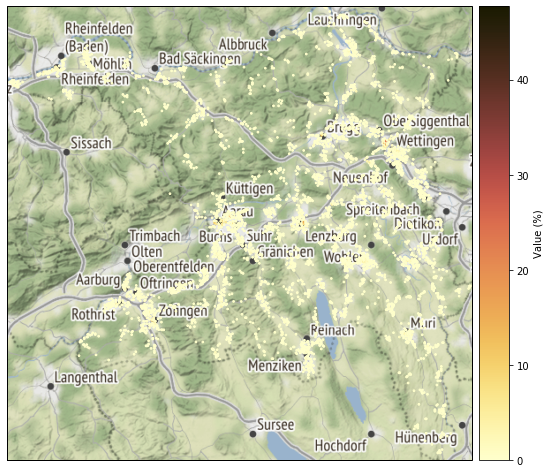

In [888]:
aargau_2050_fraction_high.plot_basemap(s=3,cmap=cm)

plt.savefig(''.join([fig_dir,'cantons/Aargau/basemap_percentage_inside_high_aargau_2050_rcp85.pdf']),bbox_inches='tight')


### Comparing Cantons

get the exposures for the different cantons. takes a lot of time (30 minutes for 5 cantons)

In [890]:
shp_dir = '../../input_data/shapefiles/KANTONS_projected_epsg4326/swissBOUNDARIES3D_1_3_TLM_KANTONSGEBIET_epsg4326.shp'

#dictionnaries in which to save the impact for the low/high expenditure of the given cantons for 2050.

cantons = ['Zürich','Genève','Luzern','Valais','Ticino']

cantons_2050_fraction_low = pd.DataFrame(columns = list(MATRICES.keys()), index = cantons)
cantons_2050_fraction_high = pd.DataFrame(columns = list(MATRICES.keys()), index = cantons)

exposures_cantons = {}

for c_ in cantons:
    exposures_cantons[c_]= call_exposures(kanton = c_)





2020-03-01 15:22:44,226 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2020-03-01 15:22:44,831 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-03-01 15:22:44,832 - climada.entity.exposures.base - INFO - tag metadata set to default value:  File: 
 Description: 
2020-03-01 15:22:44,832 - climada.entity.exposures.base - INFO - ref_year metadata set to default value: 2018
2020-03-01 15:22:44,833 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2020-03-01 15:22:44,834 - climada.entity.exposures.base - INFO - centr_ not set.
2020-03-01 15:22:44,835 - climada.entity.exposures.base - INFO - deductible not set.
2020-03-01 15:22:44,835 - climada.entity.exposures.base - INFO - cover not set.
2020-03-01 15:22:44,836 - climada.entity.exposures.base - INFO - category_id not set.
2020-03-01 15:22:44,836 - climada.entity.exposures.base - INFO - region_id not set.
2020-03

2020-03-01 15:32:04,382 - climada.entity.exposures.base - INFO - ref_year metadata set to default value: 2018
2020-03-01 15:32:04,383 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2020-03-01 15:32:04,384 - climada.entity.exposures.base - INFO - centr_ not set.
2020-03-01 15:32:04,384 - climada.entity.exposures.base - INFO - deductible not set.
2020-03-01 15:32:04,385 - climada.entity.exposures.base - INFO - cover not set.
2020-03-01 15:32:04,385 - climada.entity.exposures.base - INFO - category_id not set.
2020-03-01 15:32:04,386 - climada.entity.exposures.base - INFO - region_id not set.
2020-03-01 15:33:10,323 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2020-03-01 15:33:10,589 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-03-01 15:33:10,589 - climada.entity.exposures.base - INFO - tag metadata set to default value:  File: 
 Description: 
2020-03

2020-03-01 15:41:24,230 - climada.entity.exposures.base - INFO - deductible not set.
2020-03-01 15:41:24,230 - climada.entity.exposures.base - INFO - cover not set.
2020-03-01 15:41:24,231 - climada.entity.exposures.base - INFO - category_id not set.
2020-03-01 15:41:24,231 - climada.entity.exposures.base - INFO - region_id not set.
2020-03-01 15:42:38,818 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2020-03-01 15:42:39,048 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-03-01 15:42:39,049 - climada.entity.exposures.base - INFO - tag metadata set to default value:  File: 
 Description: 
2020-03-01 15:42:39,049 - climada.entity.exposures.base - INFO - ref_year metadata set to default value: 2018
2020-03-01 15:42:39,050 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2020-03-01 15:42:39,051 - climada.entity.exposures.base - INFO - centr_ not set.
2020-03

rebuilt the impacts for the different cantons from the impact matrix.
next, we sum all the impacts in a year for the cantons and we devide those by the total yearly value of the exposures

In [892]:
for s_ in matrices: # the Impacts are reconstructed and transformed to exposures, 
                    # as we already have a function for the impact class to mask the values outside the cantons

    for c_ in cantons: #apply the mask for the given canton and devide by the yearly value of the exposure
            cantons_2050_fraction_low[s_][c_] = vector_shapefile_mask(impact_low_2050[s_],shp_dir,c_,4326,4326).value.sum()\
            /(exposures_cantons[c_]['inside low physical activity'].value.sum()*8*5*52)*100   #devide by exposures multiplied by the number of
                                                                                        #hours worked in a year
            cantons_2050_fraction_high[s_][c_] = vector_shapefile_mask(impact_high_2050[s_],shp_dir,c_,4326,4326).value.sum()\
            /(exposures_cantons[c_]['outside high physical activity'].value.sum()*8*5*52)*100


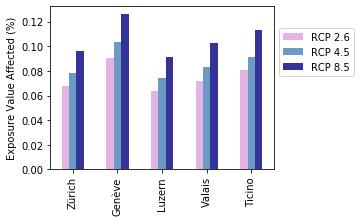

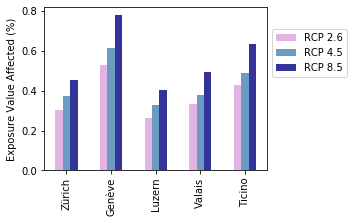

In [893]:
#barplot for 2050 showing the percentage of exposures affected for the different scenarios in the different cantons
cantons_2050_fraction_low.columns = ['RCP 2.6', 'RCP 4.5', 'RCP 8.5']
cantons_2050_fraction_high.columns = ['RCP 2.6', 'RCP 4.5', 'RCP 8.5']


fig, ax = plt.subplots(figsize=(4,3))
cantons_2050_fraction_low.plot(kind='bar',color=['plum','steelblue','navy'],ax=ax,alpha=0.8)
ax.set_ylabel("Exposure Value Affected (%)")
ax.legend(bbox_to_anchor=(1, 0.9))

plt.savefig(''.join([fig_dir,'cantons/cantons_percentage_low.pdf']),bbox_inches='tight')

fig, ax = plt.subplots(figsize=(4,3))
cantons_2050_fraction_high.plot(kind='bar',color=['plum','steelblue','navy'],ax=ax,alpha=0.8)
ax.set_ylabel("Exposure Value Affected (%)")
ax.legend(bbox_to_anchor=(1, 0.9))

plt.savefig(''.join([fig_dir,'cantons/cantons_percentage_high.pdf']),bbox_inches='tight')


## Branches
Example construction branches in the canton of Geneva

In [62]:
exposures_ge_construction = call_exposures(kanton='Genève', branch=['B170841VZA','B170842VZA','B170843VZA'])

2020-03-03 11:03:18,184 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2020-03-03 11:03:18,311 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-03-03 11:03:18,312 - climada.entity.exposures.base - INFO - tag metadata set to default value:  File: 
 Description: 
2020-03-03 11:03:18,313 - climada.entity.exposures.base - INFO - ref_year metadata set to default value: 2018
2020-03-03 11:03:18,313 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2020-03-03 11:03:18,314 - climada.entity.exposures.base - INFO - centr_ not set.
2020-03-03 11:03:18,314 - climada.entity.exposures.base - INFO - deductible not set.
2020-03-03 11:03:18,315 - climada.entity.exposures.base - INFO - cover not set.
2020-03-03 11:03:18,315 - climada.entity.exposures.base - INFO - category_id not set.
2020-03-03 11:03:18,316 - climada.entity.exposures.base - INFO - region_id not set.


In [58]:
exposures_ge = call_exposures(kanton='Genève')
exposures_ge['outside high physical activity'].value=exposures_ge_construction['outside high physical activity'].value*8*52*5 

2020-03-03 10:56:43,638 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2020-03-03 10:56:43,763 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-03-03 10:56:43,763 - climada.entity.exposures.base - INFO - tag metadata set to default value:  File: 
 Description: 
2020-03-03 10:56:43,764 - climada.entity.exposures.base - INFO - ref_year metadata set to default value: 2018
2020-03-03 10:56:43,764 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2020-03-03 10:56:43,765 - climada.entity.exposures.base - INFO - centr_ not set.
2020-03-03 10:56:43,765 - climada.entity.exposures.base - INFO - deductible not set.
2020-03-03 10:56:43,766 - climada.entity.exposures.base - INFO - cover not set.
2020-03-03 10:56:43,767 - climada.entity.exposures.base - INFO - category_id not set.
2020-03-03 10:56:43,768 - climada.entity.exposures.base - INFO - region_id not set.
2020-03

In [63]:
exposures_ge_construction['outside high physical activity'].value=exposures_ge_construction['outside high physical activity'].value*8*52*5
exposures_ge['outside high physical activity'].value=exposures_ge['outside high physical activity'].value*8*52*5 

In [61]:
exposures_ge_construction['outside high physical activity'].value.sum()/exposures_ge['outside high physical activity'].value.sum()

3078383.906981161

rebuilt impact for Geneva, calculate median cost as well as quantiles

In [64]:
pickle_in = open('../../output/impact_cantons/matrix_B170841VZA_B170842VZA_B170843VZA_1000mc_all_uncertainties_Genève.pickle','rb')
construction_ge_matrix = pickle.load(pickle_in)
pickle_in = open('../../output/impact_cantons/impacts_B170841VZA_B170842VZA_B170843VZA_1000mc_all_uncertainties_Genève.pickle','rb')
construction_ge = pickle.load(pickle_in)

ge_construction_2050_percentage = pd.DataFrame(columns = list(construction_ge.keys()),index=['median','min','max'])
ge_construction_2050_percentage_impact={}

for s_ in construction_ge: # the Impacts are reconstructed and transformed to exposures, as we already have a function in the impact class to mask the values outside the cantons

    ge_construction_2050_percentage_impact[s_] = Impact()
    ge_construction_2050_percentage_impact[s_].coord_exp = np.stack([exposures_ge_construction['outside high physical activity'].latitude.values,exposures_ge_construction['outside high physical activity'].longitude.values], axis=1)
    ge_construction_2050_percentage_impact[s_].event_id = 1
    ge_construction_2050_percentage_impact[s_].imp_mat =csr_matrix((construction_ge_matrix['RCP85']['2035']['outside high physical activity'].toarray()[0,:]\
            /exposures_ge_construction['outside high physical activity'].value.replace(0, 1))*100)

    ge_construction_2050_percentage[s_]['median'] = construction_ge[s_]['2050']['outside high physical activity'].median()/(exposures_ge_construction['outside high physical activity'].value.sum())*100
    ge_construction_2050_percentage[s_]['max'] = construction_ge[s_]['2050']['outside high physical activity'].quantile(0.05)/(exposures_ge_construction['outside high physical activity'].value.sum())*100
    ge_construction_2050_percentage[s_]['min'] = construction_ge[s_]['2050']['outside high physical activity'].quantile(0.95)/(exposures_ge_construction['outside high physical activity'].value.sum())*100


In [50]:
ge_construction_2050_percentage_impact

{'RCP26': <climada.engine.impact.Impact at 0x1c2ccf1eb8>,
 'RCP45': <climada.engine.impact.Impact at 0x1c2ca74550>,
 'RCP85': <climada.engine.impact.Impact at 0x1c2a76e550>}

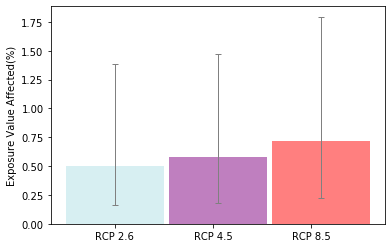

In [65]:
fig, ax = plt.subplots()
b_width = 0.21
colors =['powderblue','purple','red']

for j_,s_ in enumerate(ge_construction_2050_percentage):
    
    err = np.array([[ge_construction_2050_percentage[s_]['median']-ge_construction_2050_percentage[s_]['min']],[ge_construction_2050_percentage[s_]['max']-ge_construction_2050_percentage[s_]['median']]])

    ax.bar(j_*b_width,ge_construction_2050_percentage[s_]['median'],width = 0.2, yerr=err, error_kw=dict(barsabove=True, elinewidth=1, capsize=3,ecolor='gray'),label=s_,color = colors[j_],alpha=0.5)

    
        #ax.legend(h[:lc], l[:lc], loc=[1.01, 0.5])
        #ax.add_artist(l2)
#ax.set_title('Construction Sector Geneva 2050')
ax.set_ylabel('Exposure Value Affected(%)')
plt.xticks([0,0.2,0.4],['RCP 2.6','RCP 4.5','RCP 8.5'])

plt.savefig(''.join([fig_dir,'cantons/Geneva/geneva_construction_sector_percentage.pdf']),bbox_inches='tight')




In [901]:
#yearly exposures:


2020-03-03 11:04:31,473 - climada.util.coordinates - INFO - Setting geometry points.
2020-03-03 11:04:31,839 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


/Users/zeliestalhanske/anaconda3/climada_python-1.3.1/climada/util/plot.py:318: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


2020-03-03 11:04:32,738 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


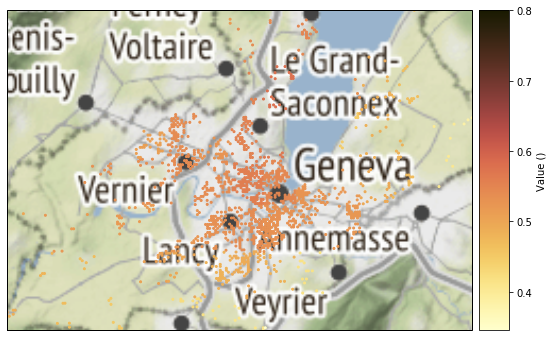

In [68]:
#plot the percentage of the yearly exposure lost

ge_construction_2050_percentage_impact['RCP85'].plot_basemap_impact_exposure(1,pop_name = False,cmap=cm,s=4,zoom=10,vmax=0.8)
plt.savefig(''.join([fig_dir,'cantons/Geneva/geneva_construction_sector_percentage_map.pdf']),bbox_inches='tight')


## Adaptation Measures

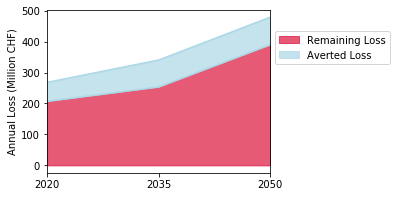

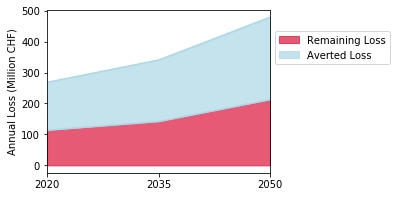

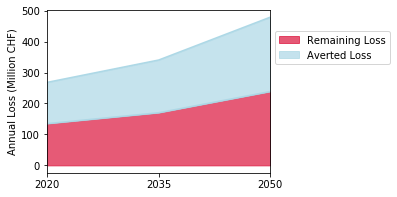

In [974]:
no_adaptation = loss_CH

#import the pickles for the adaptation measures
pickle_in = open('../../output/impact_adaptation/impacts_all_branches_1000mc_all_uncertainties_adaptation_measures1_CH.pickle','rb')
loss_shadow = pickle.load(pickle_in)

#as the loss avoided from having efficient buildings is the same as having no loss inside, 
#we can just use the loss outside for the base case 
pickle_in = open('../../output/impact_ch/impacts_all_branches_1000mc_all_uncertainties_CH.pickle','rb')
loss_efficient_buildings = pickle.load(pickle_in)

pickle_in = open('../../output/impact_adaptation/impacts_all_branches_1000mc_all_uncertainties_adaptation_measures3_6h10h16h20h_CH.pickle','rb')
loss_adapted_hours = pickle.load(pickle_in)


s = 'RCP85'
# put the different adaptation measures in a dictionnary:
adaptation_dict = {'sun_protection':loss_shadow,'efficient_buildings':loss_efficient_buildings,'adapted_hours':loss_adapted_hours}
adaptation_dict_years = {}


        
# add total 
for a_ in adaptation_dict:
    for s_ in adaptation_dict[a_]:
        for y_ in adaptation_dict[a_][s_]:
            if a_ == 'efficient_buildings':
                adaptation_dict[a_][s_][y_]['total'] = adaptation_dict[a_][s_][y_][list(adaptation_dict[a_][s_][y_].columns)]['outside high physical activity']+adaptation_dict[a_][s_][y_][list(adaptation_dict[a_][s_][y_].columns)]['outside moderate physical activity']
            
            else:
                adaptation_dict[a_][s_][y_]['total'] = adaptation_dict[a_][s_][y_][list(adaptation_dict[a_][s_][y_].columns)].sum(axis=1)
            
             
    adaptation_dict_years[a_] = {}  # make new dictionnary containing panda dataframes of the median cost with years as rows and exposures type as columns
    loss_normal_years = {}
    for s_ in adaptation_dict[a_]:
        adaptation_dict_years[a_][s_] = pd.DataFrame()
        loss_normal_years[s_] = pd.DataFrame()
        for y_ in adaptation_dict[a_][s_]:
            adaptation_dict_years[a_][s_]=adaptation_dict_years[a_][s_].append(pd.DataFrame(adaptation_dict[a_][s_][y_].median().to_dict(),index=[y_]))
            loss_normal_years[s_]=loss_normal_years[s_].append(pd.DataFrame(no_adaptation[s_][y_].median().to_dict(),index=[y_]))

    fig,ax=plt.subplots(figsize=(4,3))
    
    ax.fill_between((adaptation_dict_years[a_][s]/1000000).index,(adaptation_dict_years[a_][s]['total']/1000000),label = 'Remaining Loss',color='crimson',alpha=0.7)
    ax.fill_between(loss_normal_years[s].index,(adaptation_dict_years[a_][s]['total']/1000000),loss_normal_years[s]['total']/1000000,label = 'Averted Loss',color='lightblue',alpha=0.7)

    (adaptation_dict_years[a_][s]['total']/1000000).plot.line(ax=ax,color='lightblue',label='_nolabel_')
    (loss_normal_years[s]['total']/1000000).plot.line(ax=ax,color='lightblue',label='_nolabel_')

    ax.set_ylabel('Annual Loss (Million CHF)')
    labels = ['2020','2035','2050']
    ax.legend(bbox_to_anchor=(1, 0.9))

    plt.savefig(''.join([fig_dir,'adaptation/',a_,'.pdf']),bbox_inches='tight')


redo the same plots, but only considering the high physical activity exposures

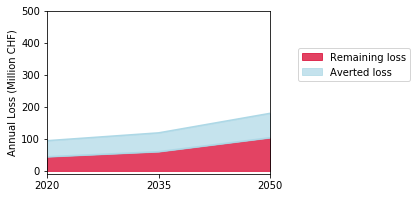

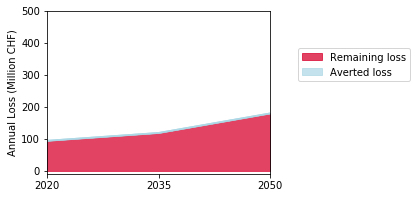

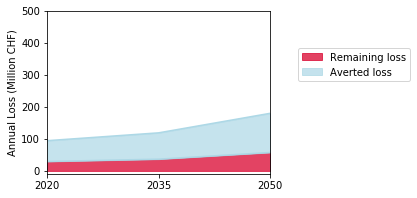

In [905]:
for a in adaptation_dict:
    fig,ax=plt.subplots(figsize=(4,3))
    ax.fill_between(adaptation_dict_years[a][s].index,adaptation_dict_years[a][s]['outside high physical activity']/1000000,label = 'Remaining loss',color='crimson',alpha=0.8)
    ax.fill_between(loss_normal_years[s].index,adaptation_dict_years[a][s]['outside high physical activity']/1000000,loss_normal_years[s]['outside high physical activity']/1000000,label = 'Averted loss',color='lightblue',alpha=0.7)

    (adaptation_dict_years[a][s]['outside high physical activity']/1000000).plot.line(ax=ax,color='lightblue',label='_nolabel_')
    (loss_normal_years[s]['outside high physical activity']/1000000).plot.line(ax=ax,color='lightblue',label='_nolabel_')

    ax.legend(bbox_to_anchor=(1.65, 0.8))
    ax.set_ylabel('Annual Loss (Million CHF)')
    labels = ['2020','2035','2050']
    ax.set_ylim(top=500)

    plt.savefig(''.join([fig_dir,'adaptation/',a,'_outside_high','.pdf']),bbox_inches='tight')



In [906]:
print('fraction loss avoided for the people working outside with high physical activity under an RCP85 in 2050')
adaptation_dict_years['sun_protection']['RCP85']['outside high physical activity']/loss_CH['RCP85']['2050']['outside high physical activity'].median()

fraction loss avoided for the people working outside with high physical activity under an RCP85 in 2050


2020    0.246147
2035    0.334324
2050    0.576874
Name: outside high physical activity, dtype: float64

In [907]:
RCP = {'RCP26':'RCP 2.6', 'RCP45':'RCP 4.5', 'RCP85':'RCP 8.5'}

#make a new dictionnary only for the year 2050 
adaptations_2050 = {}
for s_ in loss_normal_years: 
    adaptations_2050[RCP[s_]] = pd.DataFrame(columns=['Remaining Loss','Averted Loss'], index=list(adaptation_dict.keys()))
    for key in adaptation_dict:
        adaptations_2050[RCP[s_]]['Remaining Loss'][key] = adaptation_dict[key][s_]['2050']['total'].median()/1000000 
        adaptations_2050[RCP[s_]]['Averted Loss'][key] = (no_adaptation[s_]['2050']['total'].median() - adaptation_dict[key][s_]['2050']['total'].median())/1000000   
    


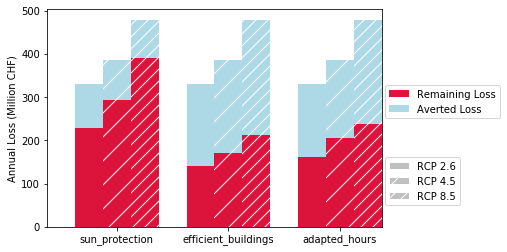

In [909]:

fig,ax=plt.subplots()

plot_clustered_stacked(ADAPTATIONS_2050,color= ['crimson','lightblue'],title= '')
plt.ylabel('Annual Loss (Million CHF)')
plt.savefig(''.join([fig_dir,'adaptation/all_adaptations','.pdf']),bbox_inches='tight')


In [910]:
print('fraction loss avoided for all exposures under an RCP85 in 2050:')

adaptations_2050['RCP 8.5']['Averted Loss']/(adaptations_2050['RCP 8.5']['Remaining Loss']+adaptations_2050['RCP 8.5']['Averted Loss'])



fraction loss avoided for all exposures under an RCP85 in 2050:


sun_protection         0.185468
efficient_buildings    0.555682
adapted_hours          0.501648
dtype: object

### Adaptation measures in the worst case scenario

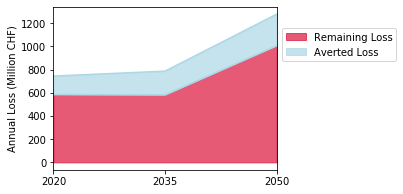

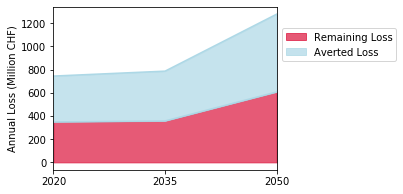

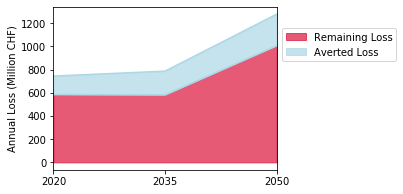

In [916]:
no_adaptation = loss_CH

# import the pickles for the adaptation measures
pickle_in = open('../../output/impact_adaptation/impacts_all_branches_1000mc_all_uncertainties_adaptation_measures1_CH.pickle','rb')
damage_shadow = pickle.load(pickle_in)

pickle_in = open('../../output/impact_ch/impacts_all_branches_1000mc_all_uncertainties_CH.pickle','rb')
damage_efficient_buildings = pickle.load(pickle_in)

pickle_in = open('../../output/impact_adaptation/impacts_all_branches_1000mc_all_uncertainties_adaptation_measures1_CH.pickle','rb')
damage_adapted_hours = pickle.load(pickle_in)


s = 'RCP85'
# put the different adaptation measures in a dictionnary:
adaptation_dict = {'Sun Protection':damage_shadow,'Efficient Buildings':damage_efficient_buildings,'Adapted Hours':damage_adapted_hours}
adaptation_dict_years = {}


        
# add total 
for a_ in adaptation_dict:
    for s_ in adaptation_dict[a_]:
        for y_ in adaptation_dict[a_][s_]:
            if a_ == 'Efficient Buildings':
                adaptation_dict[a_][s_][y_]['total'] = adaptation_dict[a_][s_][y_][list(adaptation_dict[a_][s_][y_].columns)]['outside high physical activity']+adaptation_dict[a_][s_][y_][list(adaptation_dict[a_][s_][y_].columns)]['outside moderate physical activity']
            
            else:
                adaptation_dict[a_][s_][y_]['total'] = adaptation_dict[a_][s_][y_][list(adaptation_dict[a_][s_][y_].columns)].sum(axis=1)
            
             
    adaptation_dict_years[a_] = {}  # make new dictionnary containing panda dataframes of the max cost with years as rows and exposures type as columns
    damage_normal_years = {}
    for s_ in adaptation_dict[a_]:
        adaptation_dict_years[a_][s_] = pd.DataFrame()
        damage_normal_years[s_] = pd.DataFrame()
        for y_ in adaptation_dict[a_][s_]:
            adaptation_dict_years[a_][s_]=adaptation_dict_years[a_][s_].append(pd.DataFrame(adaptation_dict[a_][s_][y_].quantile(0.95).to_dict(),index=[y_]))
            damage_normal_years[s_]=damage_normal_years[s_].append(pd.DataFrame(no_adaptation[s_][y_].quantile(0.95).to_dict(),index=[y_]))

    fig,ax=plt.subplots(figsize=(4,3))
    
    ax.fill_between((adaptation_dict_years[a_][s]/1000000).index,(adaptation_dict_years[a_][s]['total']/1000000),label = 'Remaining Loss',color='crimson',alpha=0.7)
    ax.fill_between(damage_normal_years[s].index,(adaptation_dict_years[a_][s]['total']/1000000),damage_normal_years[s]['total']/1000000,label = 'Averted Loss',color='lightblue',alpha=0.7)

    (adaptation_dict_years[a_][s]['total']/1000000).plot.line(ax=ax,color='lightblue',label='_nolabel_')
    (damage_normal_years[s]['total']/1000000).plot.line(ax=ax,color='lightblue',label='_nolabel_')

    ax.set_ylabel('Annual Loss (Million CHF)')
    labels = ['2020','2035','2050']
    ax.legend(bbox_to_anchor=(1, 0.9))

    #plt.savefig(''.join([fig_dir,a_,'_no_adaptations_worth_case_4_3','.pdf']),bbox_inches='tight')


In [917]:
RCP = {'RCP26':'RCP 2.6', 'RCP45':'RCP 4.5', 'RCP85':'RCP 8.5'}

adaptations_2050 = {}
for s_ in damage_normal_years: 
    adaptations_2050[RCP[s_]] = pd.DataFrame(columns=['Remaining Loss','Averted Loss'], index=list(adaptation_dict.keys()))
    for key in adaptation_dict:
        adaptations_2050[RCP[s_]]['Remaining Loss'][key] = adaptation_dict[key][s_]['2050']['total'].quantile(0.95)/1000000 
        adaptations_2050[RCP[s_]]['Averted Loss'][key] = (no_adaptation[s_]['2050']['total'].quantile(0.95) - adaptation_dict[key][s_]['2050']['total'].quantile(0.95))/1000000   
    


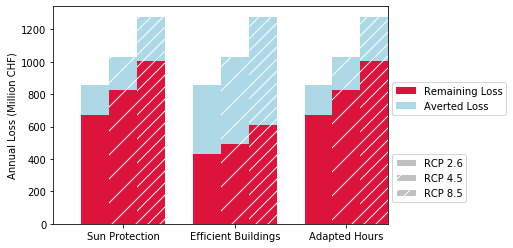

In [920]:
fig,ax=plt.subplots()

plot_clustered_stacked(adaptations_2050,color= ['crimson','lightblue'],title= '')
plt.ylabel('Annual Loss (Million CHF)')
plt.savefig(''.join([fig_dir,'adaptation/adaptations_worth_case','.pdf']),bbox_inches='tight')


# Luzern

here as opposed to the analysis on Aarau for example, the model was run specifically for Zürich

In [921]:
pickle_in = open('../../output/impact_cantons/impacts_all_branches_1000mc_all_uncertainties_Luzern.pickle','rb')
loss_Luzern= pickle.load(pickle_in)


In [922]:
for s_ in loss_Luzern:
    for y_ in loss_Luzern[s_]:     
        loss_Luzern[s_][y_]['total'] \
        = loss_Luzern[s_][y_][list(loss_Luzern[s_][y_].columns)].sum(axis=1)   
   

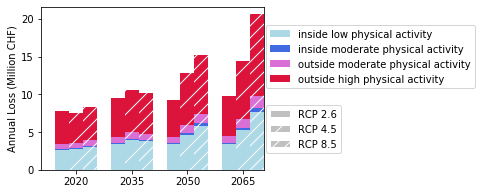

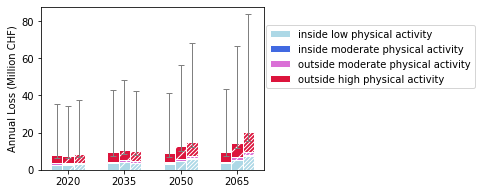

In [925]:
RCPs = {'RCP26':'RCP 2.6', 'RCP45':'RCP 4.5', 'RCP85':'RCP 8.5'}
dataframes = {}
minimums = {}
maximums = {}
for s_ in loss_Luzern:
    dataframes[RCPs[s_]] = pd.DataFrame()
    maximums[RCPs[s_]] = pd.DataFrame()
    minimums[RCPs[s_]] = pd.DataFrame()
    
    for y_ in loss_Luzern[s_]:
        dataframes[RCPs[s_]][y_] = ((loss_Luzern[s_][y_].iloc[:,0:-1]).median())/1000000
        maximums[RCPs[s_]][y_] = ((loss_Luzern[s_][y_].iloc[:,0:-1]).quantile(0.95))/1000000
        minimums[RCPs[s_]][y_] = ((loss_Luzern[s_][y_].iloc[:,0:-1]).quantile(0.05))/1000000

    
    dataframes[RCPs[s_]] = dataframes[RCPs[s_]].transpose()
    maximums[RCPs[s_]] = maximums[RCPs[s_]].transpose()
    minimums[RCPs[s_]] = minimums[RCPs[s_]].transpose()


fig, ax = plt.subplots(figsize=(4,3))
plot_clustered_stacked(dataframes,title = '',color= ['lightblue','royalblue','orchid','crimson'])
plt.ylabel('Annual Loss (Million CHF)')
ax.ticklabel_format(style='plain')

plt.savefig(''.join([fig_dir,'cantons/Luzern/predicted_loss_luzern.pdf']),bbox_inches='tight')

fig, ax = plt.subplots(figsize=(4,3))
plot_clustered_stacked_with_error(dataframes,minimums,maximums,color= ['lightblue','royalblue','orchid','crimson'])
plt.ylabel('Annual Loss (Million CHF)')
plt.savefig(''.join([fig_dir,'cantons/Luzern/predicted_loss_luzern_werror.pdf']),bbox_inches='tight')



In [928]:
pickle_in = \
open('../../output/impact_cantons/matrix_all_branches_1000mc_all_uncertainties_Luzern.pickle','rb')
matrices_Luzern= pickle.load(pickle_in)

In [929]:
for s_ in matrices_Luzern:
    for y_ in matrices_Luzern[s_]:
        matrices_Luzern[s_][y_]['outside high physical activity'] = matrices_Luzern[s_][y_]['outside high physical activity']


In [930]:
with open('../../output/impact_cantons/matrix_all_branches_1000mc_all_uncertainties_Luzern.pickle','wb') as handle:
    pickle.dump(matrices_Luzern, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [933]:
exposures_Luzern = call_exposures(kanton='Luzern')
for e_ in exposures_Luzern:
    exposures_Luzern[e_].value = exposures_Luzern[e_].value*52*40

2020-03-01 16:39:11,579 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2020-03-01 16:39:11,859 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-03-01 16:39:11,860 - climada.entity.exposures.base - INFO - tag metadata set to default value:  File: 
 Description: 
2020-03-01 16:39:11,861 - climada.entity.exposures.base - INFO - ref_year metadata set to default value: 2018
2020-03-01 16:39:11,861 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2020-03-01 16:39:11,862 - climada.entity.exposures.base - INFO - centr_ not set.
2020-03-01 16:39:11,862 - climada.entity.exposures.base - INFO - deductible not set.
2020-03-01 16:39:11,863 - climada.entity.exposures.base - INFO - cover not set.
2020-03-01 16:39:11,863 - climada.entity.exposures.base - INFO - category_id not set.
2020-03-01 16:39:11,864 - climada.entity.exposures.base - INFO - region_id not set.
2020-03

2020-03-01 16:43:48,689 - climada.util.coordinates - INFO - Setting geometry points.
2020-03-01 16:43:49,608 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


/Users/zeliestalhanske/anaconda3/climada_python-1.3.1/climada/util/plot.py:318: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


2020-03-01 16:43:53,654 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


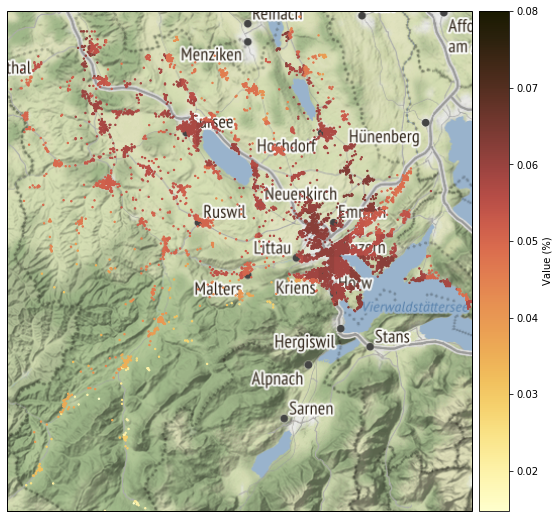

In [935]:
#inside low physical activity in percentage

median_impact_2050_RCP85_inside_low_luzern = Impact()
median_impact_2050_RCP85_inside_low_luzern.coord_exp =\
np.stack([exposures_Luzern['inside low physical activity'].latitude.values,exposures_Luzern['inside low physical activity'].longitude.values], axis=1)
median_impact_2050_RCP85_inside_low_luzern.event_id = 1
median_impact_2050_RCP85_inside_low_luzern.imp_mat =csr_matrix(MATRICES_Luzern['RCP85']['2050']['inside low physical activity']) 
median_impact_2050_RCP85_inside_low_luzern.unit = 'CHF'
cm= palettable.scientific.sequential.LaJolla_20.mpl_colormap
median_impact_2050_RCP85_inside_low_luzern.plot_basemap_impact_exposure(event_id=0,percentage=True,exposures=exposures_Luzern['inside low physical activity'],pop_name = False,cmap=cm,vmax=0.08,s=2)
plt.savefig(''.join([fig_dir,'cantons/Luzern/basemap_percentage_inside_low_luzern_2050_rcp85.pdf']),bbox_inches='tight')


2020-03-01 16:44:53,267 - climada.util.coordinates - INFO - Setting geometry points.
2020-03-01 16:44:54,155 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


/Users/zeliestalhanske/anaconda3/climada_python-1.3.1/climada/util/plot.py:318: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


2020-03-01 16:44:59,114 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


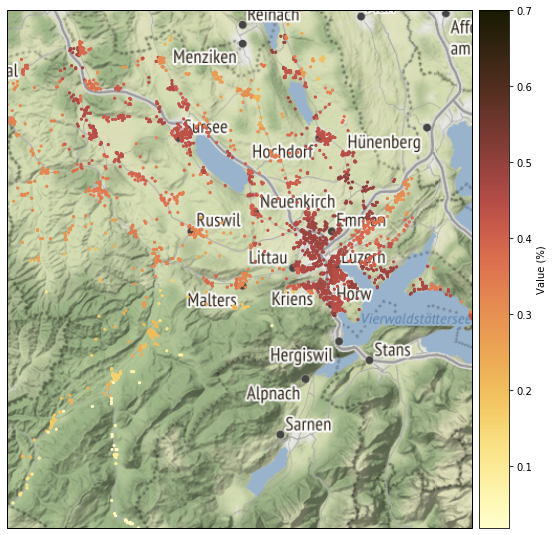

In [938]:
#outside high physical activity in percentage

median_impact_2050_RCP85_outside_high_luzern = Impact()
median_impact_2050_RCP85_outside_high_luzern.coord_exp =\
np.stack([exposures_Luzern['outside high physical activity'].latitude.values,exposures_Luzern['outside high physical activity'].longitude.values], axis=1)
median_impact_2050_RCP85_outside_high_luzern.event_id = 1
median_impact_2050_RCP85_outside_high_luzern.imp_mat =csr_matrix(matrices_Luzern['RCP85']['2050']['outside high physical activity']) 
median_impact_2050_RCP85_outside_high_luzern.unit = 'CHF'
cm= palettable.scientific.sequential.LaJolla_20.mpl_colormap
median_impact_2050_RCP85_outside_high_luzern.plot_basemap_impact_exposure(event_id=0,percentage=True,exposures=exposures_Luzern['outside high physical activity'],pop_name = False,cmap=cm,vmax=0.7,s=5)
plt.savefig(''.join([fig_dir,'cantons/Luzern/basemap_percentage_outside_high_luzern_2050_rcp85.pdf']),bbox_inches='tight')


In [ ]:
no_adaptation = loss_Luzern

# import the pickles for the adaptation measures
pickle_in = open('../../output/impact_adaptation/impacts_all_branches_1000mc_all_uncertainties_adaptation_measures1_CH.pickle','rb')
damage_shadow = pickle.load(pickle_in)

pickle_in = open('../../output/impact_ch/impacts_all_branches_1000mc_all_uncertainties_CH.pickle','rb')
damage_efficient_buildings = pickle.load(pickle_in)

pickle_in = open('../../output/impact_adaptation/impacts_all_branches_1000mc_all_uncertainties_adaptation_measures1_CH.pickle','rb')
damage_adapted_hours = pickle.load(pickle_in)


s = 'RCP85'
# put the different adaptation measures in a dictionnary:
adaptation_dict = {'Sun Protection':damage_shadow,'Efficient Buildings':damage_efficient_buildings,'Adapted Hours':damage_adapted_hours}
adaptation_dict_years = {}



In [993]:
#build dictionnary with adaptation measures for Luzern by considering that those are proportional to Switzerland 
#for each category 
no_adaptation = loss_Luzern

loss_normal_years_luzern = {}
for s_ in adaptation_dict[a_]:
    loss_normal_years_luzern[s_] = pd.DataFrame()
    for y_ in adaptation_dict[a_][s_]:
        loss_normal_years_luzern[s_]=loss_normal_years_luzern[s_].append(pd.DataFrame(no_adaptation[s_][y_].median().to_dict(),index=[y_]))


adaptation_dict_years_luzern = {}
for a_ in adaptation_dict:
    adaptation_dict_years_luzern[a_] = {}
    for s_ in adaptation_dict_years[a_]:
        adaptation_dict_years_luzern[a_][s_] = pd.DataFrame()
        for e_ in adaptation_dict_years[a_][s_]:
            if e_ != 'total':
                adaptation_dict_years_luzern[a_][s_][e_] = adaptation_dict_years[a_][s_][e_]/loss_normal_years[s_][e_]*loss_normal_years_luzern[s_][e_]
                if a_ == 'Efficient Buildings':
                    if e_ == 'inside low expenditure' or e_ == 'inside moderate expenditure':
                        adaptation_dict_years_luzern[a_][s_][e_] = 0
        adaptation_dict_years_luzern[a_][s_]['total'] \
            = adaptation_dict_years_luzern[a_][s_][list(adaptation_dict_years_luzern[a_][s_].columns)].sum(axis=1)      
            
            

sun_protection
efficient_buildings
adapted_hours


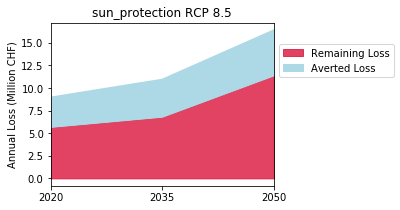

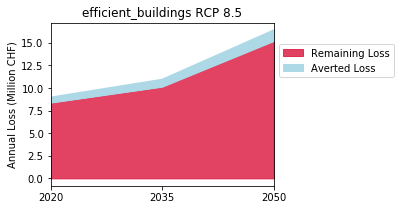

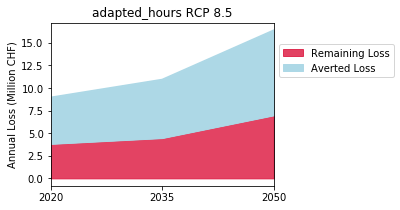

In [994]:
s='RCP85'
for a_ in adaptation_dict_years_luzern:
    print(a_)

    fig,ax=plt.subplots(figsize=(4,3))
    
    ax.fill_between((adaptation_dict_years_luzern[a_][s]/1000000).index,(adaptation_dict_years_luzern[a_][s]['total']/1000000),label = 'Remaining Loss',color='crimson',alpha=0.8)
    ax.fill_between(loss_normal_years_luzern[s].index,(adaptation_dict_years_luzern[a_][s]['total']/1000000),loss_normal_years_luzern[s]['total']/1000000,label = 'Averted Loss',color='lightblue')

    (adaptation_dict_years_luzern[a_][s]['total']/1000000).plot.line(ax=ax,color='lightblue',label='_nolabel_')
    (loss_normal_years_luzern[s]['total']/1000000).plot.line(ax=ax,color='lightblue',label='_nolabel_')

    ax.set_ylabel('Annual Loss (Million CHF)')
    labels = ['2020','2035','2050']
    ax.legend(bbox_to_anchor=(1, 0.9))
    ax.set_title(a_ + ' RCP 8.5')
    plt.savefig(''.join([fig_dir,'cantons/Luzern',a_,'_luzern.pdf']),bbox_inches='tight')


In [995]:
#dictionnary of the year 2050

RCP = {'RCP26':'RCP 2.6', 'RCP45':'RCP 4.5', 'RCP85':'RCP 8.5'}

adaptations_2050_luzern = {}
for s_ in damage_normal_years_luzern: 
    adaptations_2050_luzern[RCP[s_]] = pd.DataFrame(columns=['Remaining Loss','Averted Loss'], index=list(adaptation_dict_years_luzern.keys()))
    for key in adaptation_dict_years_luzern:
        adaptations_2050_luzern[RCP[s_]]['Remaining Loss'][key] = adaptation_dict_years_luzern[key][s_]['total']['2050']/1000000 
        adaptations_2050_luzern[RCP[s_]]['Averted Loss'][key] = (loss_Luzern[s_]['2050']['total'].median() - adaptation_dict_years_luzern[key][s_]['total']['2050'])/1000000   
  



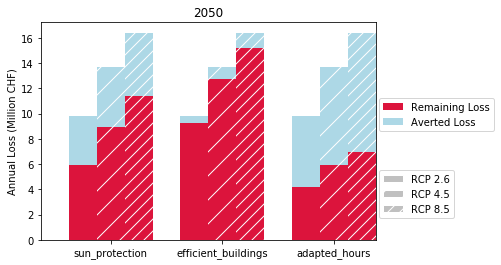

In [996]:
fig,ax=plt.subplots()

plot_clustered_stacked(adaptations_2050_luzern,color= ['crimson','lightblue'],title= '2050')
plt.ylabel('Annual Loss (Million CHF)')
plt.savefig(''.join([fig_dir,'cantons/Luzern/adaptations_luzern','.pdf']),bbox_inches='tight')


In [19]:
event_ids = np.array([0])
test = sum(median_impact_2050_RCP85_outside_high.imp_mat.toarray()[i, :] for i in event_ids)

In [27]:
median_impact_2050_RCP85_outside_high.imp_mat.toarray()[0, :]

array([0.7530433, 0.       , 0.7530433, ..., 0.       , 0.       ,
       0.       ])

In [26]:
median_impact_2050_RCP85_outside_high.imp_mat.toarray()[0, :]+median_impact_2050_RCP85_outside_high.imp_mat.toarray()[0, :]

array([1.5060866, 0.       , 1.5060866, ..., 0.       , 0.       ,
       0.       ])